# 訓練済みモデルダウンロード

In [1]:
model_urls = {
    "face_paint_512_v0.pt": "https://drive.google.com/uc?id=1WK5Mdt6mwlcsqCZMHkCUSDJxN1UyFi0-",
    "face_paint_512_v2_0.pt": "https://drive.google.com/uc?id=18H3iK09_d54qEDoWIc82SyWB2xun4gjU",
}
model_file_name = "face_paint_512_v2_0.pt"

In [2]:
!gdown {model_urls[model_file_name]}

Downloading...
From: https://drive.google.com/uc?id=18H3iK09_d54qEDoWIc82SyWB2xun4gjU
To: /content/face_paint_512_v2_0.pt
100% 8.60M/8.60M [00:00<00:00, 72.5MB/s]


# モデルロード

In [3]:
!git clone https://github.com/bryandlee/animegan2-pytorch animegan2_pytorch

Cloning into 'animegan2_pytorch'...
remote: Enumerating objects: 184, done.
remote: Counting objects: 100% (184/184), done.
remote: Compressing objects: 100% (164/164), done.
remote: Total 184 (delta 89), reused 73 (delta 19), pack-reused 0
Receiving objects: 100% (184/184), 37.77 MiB | 30.33 MiB/s, done.
Resolving deltas: 100% (89/89), done.


In [4]:
import torch
from animegan2_pytorch.model import Generator

device = 'cpu'

torch.set_grad_enabled(False)

model = Generator().eval().to(device)
model.load_state_dict(torch.load(model_file_name))

<All keys matched successfully>

# ONNX変換

In [5]:
def convert_to_onnx(net, file_name='output.onnx', input_shape=(512, 512), device='cpu'):
    input = torch.randn(1, 3, input_shape[0], input_shape[1]).to(device)

    input_layer_names = ['input_image']
    output_layer_names = ['output_image']

    torch.onnx.export(
        net, 
        input, 
        file_name, 
        verbose=True,
        opset_version=13,
        input_names=input_layer_names,
        output_names=output_layer_names,
    )

In [6]:
# 入力画像の一辺の長さ
side_length = 512
# ONNXファイル名
output_file_name = model_file_name.replace('512', str(side_length)).replace('.pt', '.onnx')

# ONNX変換
convert_to_onnx(model, output_file_name, (side_length, side_length), device)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


graph(%input_image : Float(1, 3, 512, 512, strides=[786432, 262144, 512, 1], requires_grad=0, device=cpu),
      %block_a.0.1.weight : Float(32, 3, 7, 7, strides=[147, 49, 7, 1], requires_grad=1, device=cpu),
      %block_a.1.1.weight : Float(64, 32, 3, 3, strides=[288, 9, 3, 1], requires_grad=1, device=cpu),
      %block_a.2.1.weight : Float(64, 64, 3, 3, strides=[576, 9, 3, 1], requires_grad=1, device=cpu),
      %block_b.0.1.weight : Float(128, 64, 3, 3, strides=[576, 9, 3, 1], requires_grad=1, device=cpu),
      %block_b.1.1.weight : Float(128, 128, 3, 3, strides=[1152, 9, 3, 1], requires_grad=1, device=cpu),
      %block_c.0.1.weight : Float(128, 128, 3, 3, strides=[1152, 9, 3, 1], requires_grad=1, device=cpu),
      %block_c.1.layers.0.1.weight : Float(256, 128, 1, 1, strides=[128, 1, 1, 1], requires_grad=1, device=cpu),
      %block_c.1.layers.1.1.weight : Float(256, 1, 3, 3, strides=[9, 9, 3, 1], requires_grad=1, device=cpu),
      %block_c.1.layers.1.1.bias : Float(256, stride

In [7]:
!pip install onnx-simplifier

     |████████████████████████████████| 12.7 MB 7.4 MB/s 
     |████████████████████████████████| 466 kB 52.9 MB/s 
     |████████████████████████████████| 4.8 MB 39.5 MB/s 
  Created wheel for onnx-simplifier: filename=onnx_simplifier-0.3.6-py3-none-any.whl size=12873 sha256=06b6496c0271ced2608aaa61e26e9ac87a67df2cfc812d91b54be75d28cfd699
  Stored in directory: /root/.cache/pip/wheels/0c/47/80/8eb21098e22c19d60b1c14021ee67442b4ad2d7991fdad46ba
Successfully built onnx-simplifier


In [8]:
!python -m onnxsim $output_file_name $output_file_name

Simplifying...
Checking 0/3...
Checking 1/3...
Checking 2/3...
Ok!


# 推論テスト

In [9]:
!pip install onnxruntime imread_from_url

  Created wheel for imread-from-url: filename=imread_from_url-0.1-py3-none-any.whl size=6437 sha256=b5979d8efd3ad5ca10a9f9e6b553944262dca03827259fb16d9cc630ea6d44c1
  Stored in directory: /root/.cache/pip/wheels/91/c3/b4/d279fec72bc92251f0e2787052f7dc93c46b56d7a1a2e45dab
Successfully built imread-from-url


In [10]:
import onnxruntime

# ONNXモデルロード
onnx_session = onnxruntime.InferenceSession(output_file_name)

input_name = onnx_session.get_inputs()[0].name
output_name = onnx_session.get_outputs()[0].name

In [11]:
from imread_from_url import imread_from_url

image = imread_from_url('https://user-images.githubusercontent.com/37477845/141307389-2437d167-d64b-48ce-8a80-aac5db2195b8.jpg')

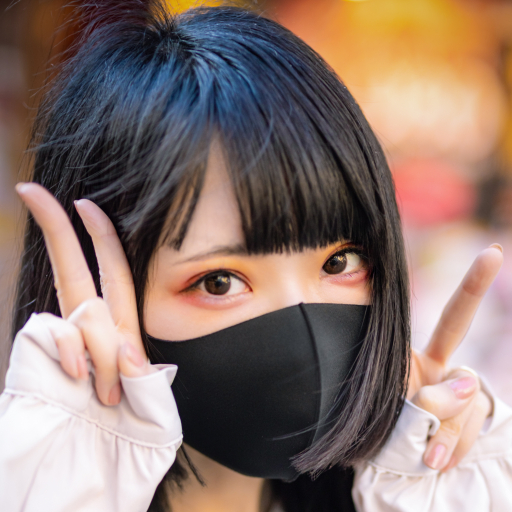

In [12]:
from google.colab.patches import cv2_imshow

cv2_imshow(image)

In [13]:
import cv2 as cv
import numpy as np

# 前処理
image = cv.resize(image, dsize=(side_length, side_length))
x = cv.cvtColor(image, cv.COLOR_BGR2RGB)

x = np.array(x, dtype=np.float32)
x = x.transpose(2, 0, 1)
x = x * 2 - 1
x = x.reshape(-1, 3, side_length, side_length)

# 推論
onnx_result = onnx_session.run([output_name], {input_name: x})

# 後処理
onnx_result = np.array(onnx_result).squeeze()
onnx_result = (onnx_result * 0.5 + 0.5).clip(0, 1)
onnx_result = onnx_result * 255

onnx_result = onnx_result.transpose(1, 2, 0).astype('uint8')
onnx_result = cv.cvtColor(onnx_result, cv.COLOR_RGB2BGR)

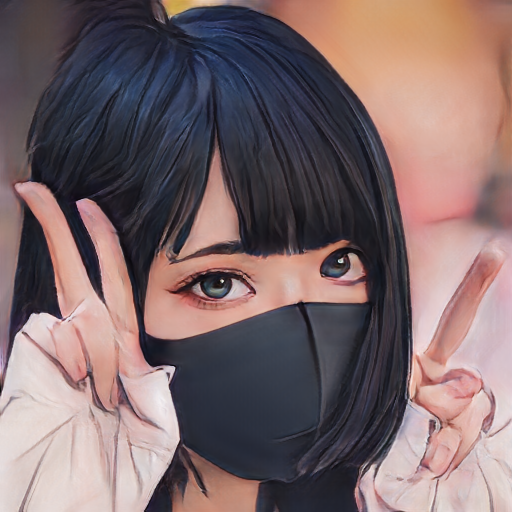

In [14]:
cv2_imshow(onnx_result)